# Health Catalyst data science take-home Test By Yi 'Evelyn' He

In [1]:
# created by Evelyn on Tue Sep20 15:01 2016


import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import pandas.io.sql
import pyodbc
import datetime as DT
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from time import time
from operator import itemgetter

Here I will use a local SQL Server environment---

In [2]:
## Define parameters
server = 'EVELYN-X200\SQLEXPRESS'
db = 'AdventureWorks2012'

# Create the connection
connection = pyodbc.connect('DRIVER={SQL Server};SERVER=' + server + ';DATABASE=' + db + ';Trusted_Connection=yes')

# query db
sql = """

SELECT  *  FROM HumanResources.Employee

"""

#load data to Python dataframe
df = pandas.io.sql.read_sql(sql, connection)
df.head()

,BusinessEntityID,NationalIDNumber,LoginID,OrganizationNode,OrganizationLevel,JobTitle,BirthDate,MaritalStatus,Gender,HireDate,SalariedFlag,VacationHours,SickLeaveHours,CurrentFlag,rowguid,ModifiedDate
0,1,295847284,adventure-works\ken0,[],0,Chief Executive Officer,1963-03-02,S,M,2003-02-15,True,99,69,True,F01251E5-96A3-448D-981E-0F99D789110D,2008-07-31
1,2,245797967,adventure-works\terri0,[88],1,Vice President of Engineering,1965-09-01,S,F,2002-03-03,True,1,20,True,45E8F437-670D-4409-93CB-F9424A40D6EE,2008-07-31
2,3,509647174,adventure-works\roberto0,"[90, 192]",2,Engineering Manager,1968-12-13,M,M,2001-12-12,True,2,21,True,9BBBFB2C-EFBB-4217-9AB7-F97689328841,2008-07-31
3,4,112457891,adventure-works\rob0,"[90, 214]",3,Senior Tool Designer,1969-01-23,S,M,2002-01-05,False,48,80,True,59747955-87B8-443F-8ED4-F8AD3AFDF3A9,2008-07-31
4,5,695256908,adventure-works\gail0,"[90, 218]",3,Design Engineer,1946-10-29,M,F,2002-02-06,True,5,22,True,EC84AE09-F9B8-4A15-B4A9-6CCBAB919B08,2008-07-31


In [3]:
#check dimensions of dataframe
print ("The dimensions of the dataframe we've got are "+ str(df.shape))

The dimensions of the dataframe we've got are (290, 16)


In [4]:
# check missing values--no missing values
print np.sum(df.isnull())

BusinessEntityID     0
NationalIDNumber     0
LoginID              0
OrganizationNode     0
OrganizationLevel    0
JobTitle             0
BirthDate            0
MaritalStatus        0
Gender               0
HireDate             0
SalariedFlag         0
VacationHours        0
SickLeaveHours       0
CurrentFlag          0
rowguid              0
ModifiedDate         0
dtype: int64


We can see there is no missing value.


Also we want to take a look at the types of all columns in dataframe

In [5]:
# check types of all columns
print df.dtypes

BusinessEntityID              int64
NationalIDNumber             object
LoginID                      object
OrganizationNode             object
OrganizationLevel             int64
JobTitle                     object
BirthDate                    object
MaritalStatus                object
Gender                       object
HireDate                     object
SalariedFlag                   bool
VacationHours                 int64
SickLeaveHours                int64
CurrentFlag                    bool
rowguid                      object
ModifiedDate         datetime64[ns]
dtype: object


Then we begin to pre-process data.


Firstly  we want to identify unnecessary variables for classification models.

To do this we need to check how many unique values in each column.

In [6]:
#clean and pre-process data
#pre-processing-1 identify unnecessary variables for classification

#according to the data dictionary(http://www.sqldatadictionary.com/AdventureWorks2012.pdf)
#and also check amount of unique values in each column to determine unnecessary variables
print len(df.BusinessEntityID.unique())
print len(df.NationalIDNumber.unique())
print len(df.LoginID.unique())

# convert hierarchyid to string values
df['OrganizationNode'] = df['OrganizationNode'].astype(str)
print len(df.OrganizationNode.unique())

print len(df.OrganizationLevel.unique())
print len(df.JobTitle.unique())
print len(df.BirthDate.unique())
print len(df.MaritalStatus.unique())
print len(df.Gender.unique())
print len(df.HireDate.unique())
print len(df.VacationHours.unique())
print len(df.SickLeaveHours.unique())
print len(df.CurrentFlag.unique())
print len(df.rowguid.unique())
print len(df.ModifiedDate.unique())

290
290
290
290
5
67
279
2
2
164
100
51
1
290
2



We can see there are 5 columns ("BusinessEntityID", "NationalIDNumber", "LoginID",  "OrganizationNode", "rowguid") with 290 unique values (we have 290 records totally), which means here they play the role just like identifiers.


We can exclude them from classification modeling.


Another column we will drop is CurrentFlag, since it has only one value for all records

In [7]:
#drop columns with 290 unique values from classification
list_id = ["BusinessEntityID", "NationalIDNumber", "LoginID", 
                   "OrganizationNode", "rowguid"]
df_no_id = df.drop(list_id, 1)                 

#drop CurrentFlag since it has only one value
df_no_CurrentFlag = df_no_id.drop(['CurrentFlag'], 1)

#again check shape of dataset
print ("The dimensions of the dataframe we've got are "+ str(df_no_CurrentFlag.shape))
print ("")
print df_no_CurrentFlag.head()

The dimensions of the dataframe we've got are (290, 10)

   OrganizationLevel                       JobTitle   BirthDate MaritalStatus  \
0                  0        Chief Executive Officer  1963-03-02             S   
1                  1  Vice President of Engineering  1965-09-01             S   
2                  2            Engineering Manager  1968-12-13             M   
3                  3           Senior Tool Designer  1969-01-23             S   
4                  3                Design Engineer  1946-10-29             M   

  Gender    HireDate SalariedFlag  VacationHours  SickLeaveHours ModifiedDate  
0      M  2003-02-15         True             99              69   2008-07-31  
1      F  2002-03-03         True              1              20   2008-07-31  
2      M  2001-12-12         True              2              21   2008-07-31  
3      M  2002-01-05        False             48              80   2008-07-31  
4      F  2002-02-06         True              5        



Secondly  we transform date time variables to duration:

That is, we substitute BirthDate with Age, HireDate with Work_Duration.


Another datetime variable ModifiedDate is dropped since it provides limited info for classification

In [8]:
#pre-processing-2 transform date time to duration

# get current date
now = pd.to_datetime(DT.datetime.now())
#calculate age and work_duration to substitute BirthDate and HireDate
df_no_CurrentFlag['Age'] = (now - pd.to_datetime(df_no_CurrentFlag['BirthDate'])).astype('<m8[Y]')
df_no_CurrentFlag['Work_Duration'] = (now - pd.to_datetime(df_no_CurrentFlag['HireDate'])).astype('<m8[Y]')
# also drop ModifiedDate since it provides limited info for classification
df_no_date = df_no_CurrentFlag.drop(['BirthDate', 'HireDate', 'ModifiedDate'], 1)

Thirdly we convert non-numeric variables into category type

In [9]:
#pre-process-3 convert several non-numeric variables into category type
df_no_date['OrganizationLevel'] = df_no_date['OrganizationLevel'].astype('category')
df_no_date['JobTitle'] = df_no_date['JobTitle'].astype('category')
df_no_date['MaritalStatus'] = df_no_date['MaritalStatus'].astype('category')
df_no_date['Gender'] = df_no_date['Gender'].astype('category')

Fourthly we need to handle JobTitle, since originally it has 67 levels

In [10]:
#pre-process-4 handling JobTitle(originally 67 levels)
#first check values distribution
print df_no_date['JobTitle'].value_counts()

Production Technician - WC40                26
Production Technician - WC50                26
Production Technician - WC60                26
Production Technician - WC30                25
Production Technician - WC20                22
Production Technician - WC10                17
Production Technician - WC45                15
Sales Representative                        14
Buyer                                        9
Marketing Specialist                         5
Quality Assurance Technician                 4
Application Specialist                       4
Scheduling Assistant                         4
Janitor                                      4
Production Supervisor - WC40                 3
Production Supervisor - WC60                 3
Production Supervisor - WC30                 3
Production Supervisor - WC45                 3
Accounts Receivable Specialist               3
Production Supervisor - WC10                 3
Design Engineer                              3
Marketing Ass

In [11]:
#calculate for each level the rate of response of 0 and 1
flag0 = {}
flag1 = {}
for i, title in enumerate(df_no_date['JobTitle']):
     flag0[title] = (df_no_date[(df_no_date['SalariedFlag'] == 0) & (df_no_date['JobTitle'] == title)]).shape[0]
     flag1[title] = (df_no_date[(df_no_date['SalariedFlag'] == 1) & (df_no_date['JobTitle'] == title)]).shape[0]
# calculate 0 rate of each level

title_rate = {}
for key in flag0.keys():
    title_rate[key] = float(flag0[key])/float(flag0[key] + flag1[key])

print("")
print ("The response rate of 0 for each level:" )
for k, v in title_rate.iteritems():
    print (k, v)


The response rate of 0 for each level:
(u'Document Control Manager', 1.0)
(u'Production Supervisor - WC40', 1.0)
(u'Production Supervisor - WC60', 1.0)
(u'Quality Assurance Supervisor', 0.0)
(u'Document Control Assistant', 1.0)
(u'Production Supervisor - WC45', 1.0)
(u'Facilities Administrative Assistant', 1.0)
(u'Design Engineer', 0.0)
(u'Vice President of Production', 0.0)
(u'Network Manager', 0.0)
(u'Research and Development Manager', 0.0)
(u'Tool Designer', 1.0)
(u'Production Supervisor - WC20', 1.0)
(u'Accountant', 0.0)
(u'Engineering Manager', 0.0)
(u'Control Specialist', 1.0)
(u'Senior Tool Designer', 1.0)
(u'Production Technician - WC40', 1.0)
(u'Marketing Specialist', 1.0)
(u'Production Technician - WC60', 1.0)
(u'Production Technician - WC20', 1.0)
(u'Purchasing Manager', 0.0)
(u'Human Resources Manager', 0.0)
(u'Marketing Manager', 0.0)
(u'Sales Representative', 0.0)
(u'Senior Design Engineer', 0.0)
(u'North American Sales Manager', 0.0)
(u'Production Supervisor - WC50', 1.

We can see every title must corresponds to 0 or 1.


If these records represent all possible titles, we may only use title to determine SalaryFlag.


But if there will be other titles besides these ones, we need to predict SalaryFlag with other predictors


Therefore here we drop JobTitle from classification model

In [12]:
df_no_title = df_no_date.drop(['JobTitle'], 1)

Fifthly, we create dummy variables for categorical variables

In [13]:
#pre-process-5 create dummy variables for categorical variables
df_done = pd.get_dummies(df_no_title, columns = ['OrganizationLevel','MaritalStatus', 'Gender'])



By now we complete the pre-processing of data.


Then we begin to build models and compare them.

Here Logistic Regression and Random Forest are used for classification.

Since it's a classification problem, we use accuracy as the performance evaluation metric

In [14]:
#modeling and comparison--using default parameters
#split data into 80% training set and 20% testing set
X_train, X_test, y_train, y_test = train_test_split(df_done.ix[:, 1:], df_done['SalariedFlag'], 
                                                    test_size = 0.2, random_state = 0)

In [15]:
#Logistic Regression
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)
predicted = model_LR.predict(X_test)
#probs = model_LR.predict_proba(X_test)

# generate evaluation metrics
print ("The accuracy of Logistic Regression model with default parameters is : ")
print ("")
print metrics.accuracy_score(y_test, predicted)

The accuracy of Logistic Regression model with default parameters is : 

0.827586206897


Then we build Random Forest model for classification

In [16]:
#Random Forest with default parameters
model_RF = RandomForestClassifier()
model_RF.fit(X_train, y_train)
results = model_RF.predict(X_test)
print ("The accuracy of Random Forest model with default parameters is : ")
print ("")
print accuracy_score(y_test, results)

The accuracy of Random Forest model with default parameters is : 

0.862068965517


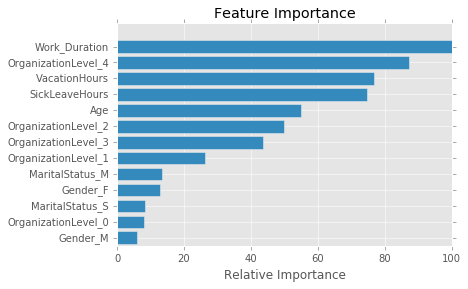

In [17]:
#plot the feature importance
importances = model_RF.feature_importances_
feature_importance = 100.0 * (importances / importances.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align = 'center')
arr = np.array(list(df_done.columns.values)[1:])
plt.yticks(pos, arr[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

In [18]:
#Random Forest only using important features to predict
df_new = df_done[['OrganizationLevel_4', 'VacationHours', 'SickLeaveHours', 'Work_Duration', 'Age',
                  'OrganizationLevel_2', 'OrganizationLevel_3']]
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df_new, df_done['SalariedFlag'], 
                                                    test_size = 0.2, random_state = 100)
model_RF_new = RandomForestClassifier()
model_RF_new.fit(X_train_new, y_train_new)
results_new = model_RF_new.predict(X_test_new)

print ("The accuracy of Random Forest model with default parameters and important predictors is : ")
print ("")
print accuracy_score(y_test_new, results_new)

The accuracy of Random Forest model with default parameters and important predictors is : 

0.948275862069


We can see the Random Forest with only important predictors is the best model comparing with Logistic Regression model and Random Forest with all predictors.

In the following section we will optimize hyperparameters using grid search for both models

In [19]:
#Hyperparameter optimization using grid search

#get parameters list of classifier
print ("The parameters of Logistic Regression model are: ")
print model_LR.get_params()

print("")

print ("The parameters of Random Forest model are: ")
print model_RF_new.get_params()

The parameters of Logistic Regression model are: 
{'warm_start': False, 'C': 1.0, 'n_jobs': 1, 'verbose': 0, 'intercept_scaling': 1, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'multi_class': 'ovr', 'random_state': None, 'dual': False, 'tol': 0.0001, 'solver': 'liblinear', 'class_weight': None}

The parameters of Random Forest model are: 
{'warm_start': False, 'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': None, 'max_features': 'auto', 'max_depth': None, 'class_weight': None}


In [20]:
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [21]:
#grid search for Logistic Regression and train from the training set
param_grid_LR = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2']}
grid_search_LR = GridSearchCV(model_LR, param_grid_LR)
start = time()
grid_search_LR.fit(X_train, y_train)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search_LR.grid_scores_)))
report(grid_search_LR.grid_scores_)

GridSearchCV took 0.29 seconds for 14 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.909 (std: 0.011)
Parameters: {'penalty': 'l1', 'C': 10}

Model with rank: 2
Mean validation score: 0.909 (std: 0.011)
Parameters: {'penalty': 'l2', 'C': 10}

Model with rank: 3
Mean validation score: 0.905 (std: 0.017)
Parameters: {'penalty': 'l1', 'C': 100}



In [22]:
# check if optimized paramters will improve model performance
model_LR_opt = LogisticRegression(C = 10, penalty = 'l1')

model_LR_opt.fit(X_train, y_train)
predicted_opt = model_LR_opt.predict(X_test)

print ("The accuracy of Logistic Regression model with optimized parameters is : ")
print metrics.accuracy_score(y_test, predicted_opt)

The accuracy of Logistic Regression model with optimized parameters is : 
0.827586206897


Here we can see we don't  get improvement after grid search and hyparameter optimization for Logistic Regression comparing with model with default parameters.

In [23]:
#grid search for Random Forest, here we use Random Forest with only important parameters-the best model
#specify parameters and distributions to sample from
param_grid_RF = {"n_estimators": [10, 100, 500, 1000],
              "min_samples_leaf": [1,2,3,4,5,6]}
grid_search_RF = GridSearchCV(model_RF_new, param_grid = param_grid_RF)
start = time()
grid_search_RF.fit(X_train_new, y_train_new)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search_RF.grid_scores_)))
report(grid_search_RF.grid_scores_)

GridSearchCV took 66.09 seconds for 24 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.935 (std: 0.021)
Parameters: {'n_estimators': 500, 'min_samples_leaf': 1}

Model with rank: 2
Mean validation score: 0.931 (std: 0.012)
Parameters: {'n_estimators': 10, 'min_samples_leaf': 1}

Model with rank: 3
Mean validation score: 0.931 (std: 0.016)
Parameters: {'n_estimators': 100, 'min_samples_leaf': 2}



In [24]:
#Random Forest only using important features with optimized parameters to predict
model_RF_opt = RandomForestClassifier(n_estimators = 500,  min_samples_leaf = 1)
model_RF_opt.fit(X_train_new, y_train_new)
results_opt = model_RF_opt.predict(X_test_new)

print ("The accuracy of Random Forest model with optimized parameters is : ")
print accuracy_score(y_test_new, results_opt)

The accuracy of Random Forest model with optimized parameters is : 
0.965517241379


Here we can see we've got improvement after grid search and hyparameter optimization for Random Forest


Finally we train the best model on the entire data set using the best hyperparameters found

In [25]:
#Train Random Forest model on the entire data set using the best hyperparameters found
#Random Forest only using important features to predict
model_RF_opt_all = RandomForestClassifier(n_estimators = 500,  min_samples_leaf = 1)
model_RF_opt_all.fit(df_new, df_done['SalariedFlag'])
results_opt_all = model_RF_opt_all.predict(df_new)

print ("The accuracy of Random Forest model with optimized parameters on entire data set is : ")
print accuracy_score(df_done['SalariedFlag'], results_opt_all)

The accuracy of Random Forest model with optimized parameters on entire data set is : 
1.0


Summary:

--During pre-processing, we removed 6 columns ("BusinessEntityID", "NationalIDNumber", "LoginID", "OrganizationNode", "rowguid", "CurrentFlag") since they have unique value for each record, or only one value for all records. Also we transformed datetime variables to duration: substitute BirthDate with Age, HireDate with Work_Duration. Another transformation is to convert non-numeric variables into category type.
Also we find JobTitle is complete separation, then we also dropped it from classification.

--With default hyperparameters we built two models: Logistics Regression and Random Forest. Apparently Random Forest with most important predictors is the best model.

--Then we implemented grid searches over two common hyperparameters for each method. For Logistics Regression we tuned C and penalty, for Random Forest we tuned n_estimators and min_samples_leaf.

--For Logistics Regression, the best hyperparameters found by grid search are C = 10, penalty = 'l1', which seemed like not improve the performance of model comparing with the defaults (C = 1.0, penalty = 'l2').


--For Random Forest, the best hyperparameters found by grid search are n_estimators = 500, min_samples_leaf = 1, which indeed improved the performance  of model comparing with the defaults (n_estimators = 10, min_samples_leaf = 1)

--Finally we train the best model on the entire data set using the best hyperparameters found.